# Forcées résonance


In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)


from scipy.signal import argrelmax, argrelmin


In [2]:
def load(filename: str):
    return pd.read_csv(filename)

In [3]:
import_path = '../data/I_75_mot'
datas_temp = []
for i in range(30):
    datas_temp.append(load(import_path + str(i+1) + '.csv'))

In [4]:
datas = []
for battement in datas_temp:
    t, x, y = battement['Temps'].to_numpy(), battement['X'].to_numpy(), battement['Y'].to_numpy()
    moyx = np.mean(x)
    moyy = np.mean(y)
    datas.append((t, x-moyx, y-moyy))

# Do the calcs

In [5]:
# some math here

# for battement in datas:
#     t, x, y = battement[0], battement[1], battement[2]
#     plt.plot(t, x)
#     plt.plot(t, y)
#     plt.show()

In [6]:
omegas = []
As = []

for battement in datas:
    t, x, y = battement[0], battement[1], battement[2]


    fourier_x = np.abs(np.fft.fft(x))
    fourier_y = np.abs(np.fft.fft(y))

    freq = np.fft.fftfreq(t.shape[-1])
    omega = np.abs(freq[np.argmax(fourier_x)] * 2*np.pi)
    Omega = np.abs(freq[np.argmax(fourier_y)] * 2*np.pi)
    # print(f'omega = {omega} = Omega = {Omega}')
    # plt.plot(freq, fourier_x)
    # plt.plot(freq, fourier_y)
    # plt.grid()
    # plt.xlim([-0.25, 0.25])
    # plt.show()
    period = 2*np.pi/omega
    delta_omega = 2*np.pi*delta_T/(period**2)
    omega = ufloat(np.mean([omega, Omega]), delta_omega)
    
    omegas.append(omega)


    extrems_x = np.concatenate((argrelmax(x, order=3)[0], argrelmin(x, order=3)[0]))
    # extrems_x = np.sort(extrems_x)
    ampl = np.abs(x)[extrems_x]
    A = ufloat(np.mean(ampl), np.std(ampl))
    As.append(A)
    # plt.vlines(t[extrems_x], ymax=0.2, ymin=-0.2)
    # plt.plot(t, x)
    # plt.show()


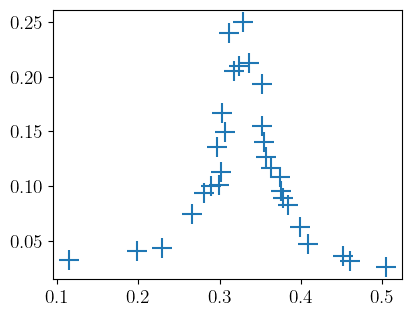

In [7]:
omegas = np.array(omegas)
As = np.array(As)

plt.scatter(nom_vals(omegas), nom_vals(As))

In [ ]:
def permanent(time, A, psi):
    return A*np.sin(omega*time - psi)

In [ ]:
coefs = sc.optimize.minimize(permanent(t), ())